In [26]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns


In [27]:
def calc_exp_qty(n, agg=True):
    '''Calculate the quantity of exported hydrogen in TWh'''
    q = n.snapshot_weightings.generators @ n.links_t.p0.filter(like="export")
    if agg:
        q = q.sum()
    return q / 1e6

def calc_elec_price(n):
    elec_mps = n.buses_t.marginal_price.filter(regex="AC$")
    elec_demand = n.loads_t.p.filter(regex="EV$|AC$")
    elec_demand.columns = elec_demand.columns.str.split(" ").str[0]
    elec_demand = elec_demand.groupby(elec_demand.columns, axis=1).sum()
    elec_costs = (elec_mps*elec_demand).sum().sum()
    return  elec_costs / elec_demand.sum().sum(), elec_costs/1e9

In [38]:
# Define the path to the networks
path = "/home/cpschau/Code/dev/BRIGHT/submodules/pypsa-earth-sec/results/241031_electrolyzer_cc_sensitivity/postnetworks"

# Initialize an empty DataFrame
df = pd.DataFrame(columns=["scenario", "mp_EUR_per_MWh", "ecc", "exp_qty_TWh", "total_cost_bnEUR", "elec_price_EUR_per_MWh", "elec_costs_bnEUR"])

# Parse the networks and fill the DataFrame
for f in os.listdir(path):
    if f.endswith("ecc.nc"):
        scenario = f.split("_")[-4]
        mp = f.split("_")[-2].strip("mp")
        ecc = f.split("_")[-1].strip("ecc.nc")
        n = pypsa.Network(f"{path}/{f}")
        
        # Calculate the necessary variables
        exp_qty_TWh = calc_exp_qty(n)  # Replace with the actual function to calculate exported hydrogen quantity
        total_cost_bnEUR = n.objective / 1e9
        elec_price_EUR_per_MWh, elec_costs_bnEUR = calc_elec_price(n)  # Replace with the actual function to calculate electricity price and costs
        
        # Append the data to the DataFrame
        new_row = pd.DataFrame([{
            "scenario": scenario,
            "mp_EUR_per_MWh": mp,
            "ecc": ecc,
            "exp_qty_TWh": exp_qty_TWh,
            "total_cost_bnEUR": total_cost_bnEUR,
            "elec_price_EUR_per_MWh": elec_price_EUR_per_MWh,
            "elec_costs_bnEUR": elec_costs_bnEUR
        }])
        df = pd.concat([df, new_row], ignore_index=True)

# Calculate system savings and electricity savings dependent variables
df["system_savings_bnEUR"] = df.apply(lambda x: max(df[(df["scenario"] == x["scenario"]) & (df["mp_EUR_per_MWh"] == "endogenous") & (df["ecc"] == x["ecc"])]["total_cost_bnEUR"].values[0] - x["total_cost_bnEUR"], 0), axis=1)
df["system_savings_EUR_per_TWh"] = df.apply(lambda x: max(x["system_savings_bnEUR"] / x["exp_qty_TWh"] * 1e9, 0) if x["exp_qty_TWh"] != 0 else 0, axis=1)

df["elec_savings_bnEUR"] = df.apply(lambda x: max(df[(df["scenario"] == x["scenario"]) & (df["mp_EUR_per_MWh"] == "endogenous") & (df["ecc"] == x["ecc"])]["elec_costs_bnEUR"].values[0] - x["elec_costs_bnEUR"], 0), axis=1)
df["elec_savings_EUR_per_TWh"] = df.apply(lambda x: max(x["elec_savings_bnEUR"] / x["exp_qty_TWh"] * 1e9, 0) if x["exp_qty_TWh"] != 0 else 0, axis=1)

df["ecc"] = df["ecc"].astype(float)
# Cast mp to int if possible
df["mp_EUR_per_MWh"] = df["mp_EUR_per_MWh"].astype(int, errors="ignore")
df.set_index(["scenario", "mp_EUR_per_MWh", "ecc"], inplace=True)
df = df.sort_index(ascending=True).sort_index(axis=1, ascending=True).reset_index()



/home/cpschau/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/cpschau/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/cpschau/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Va

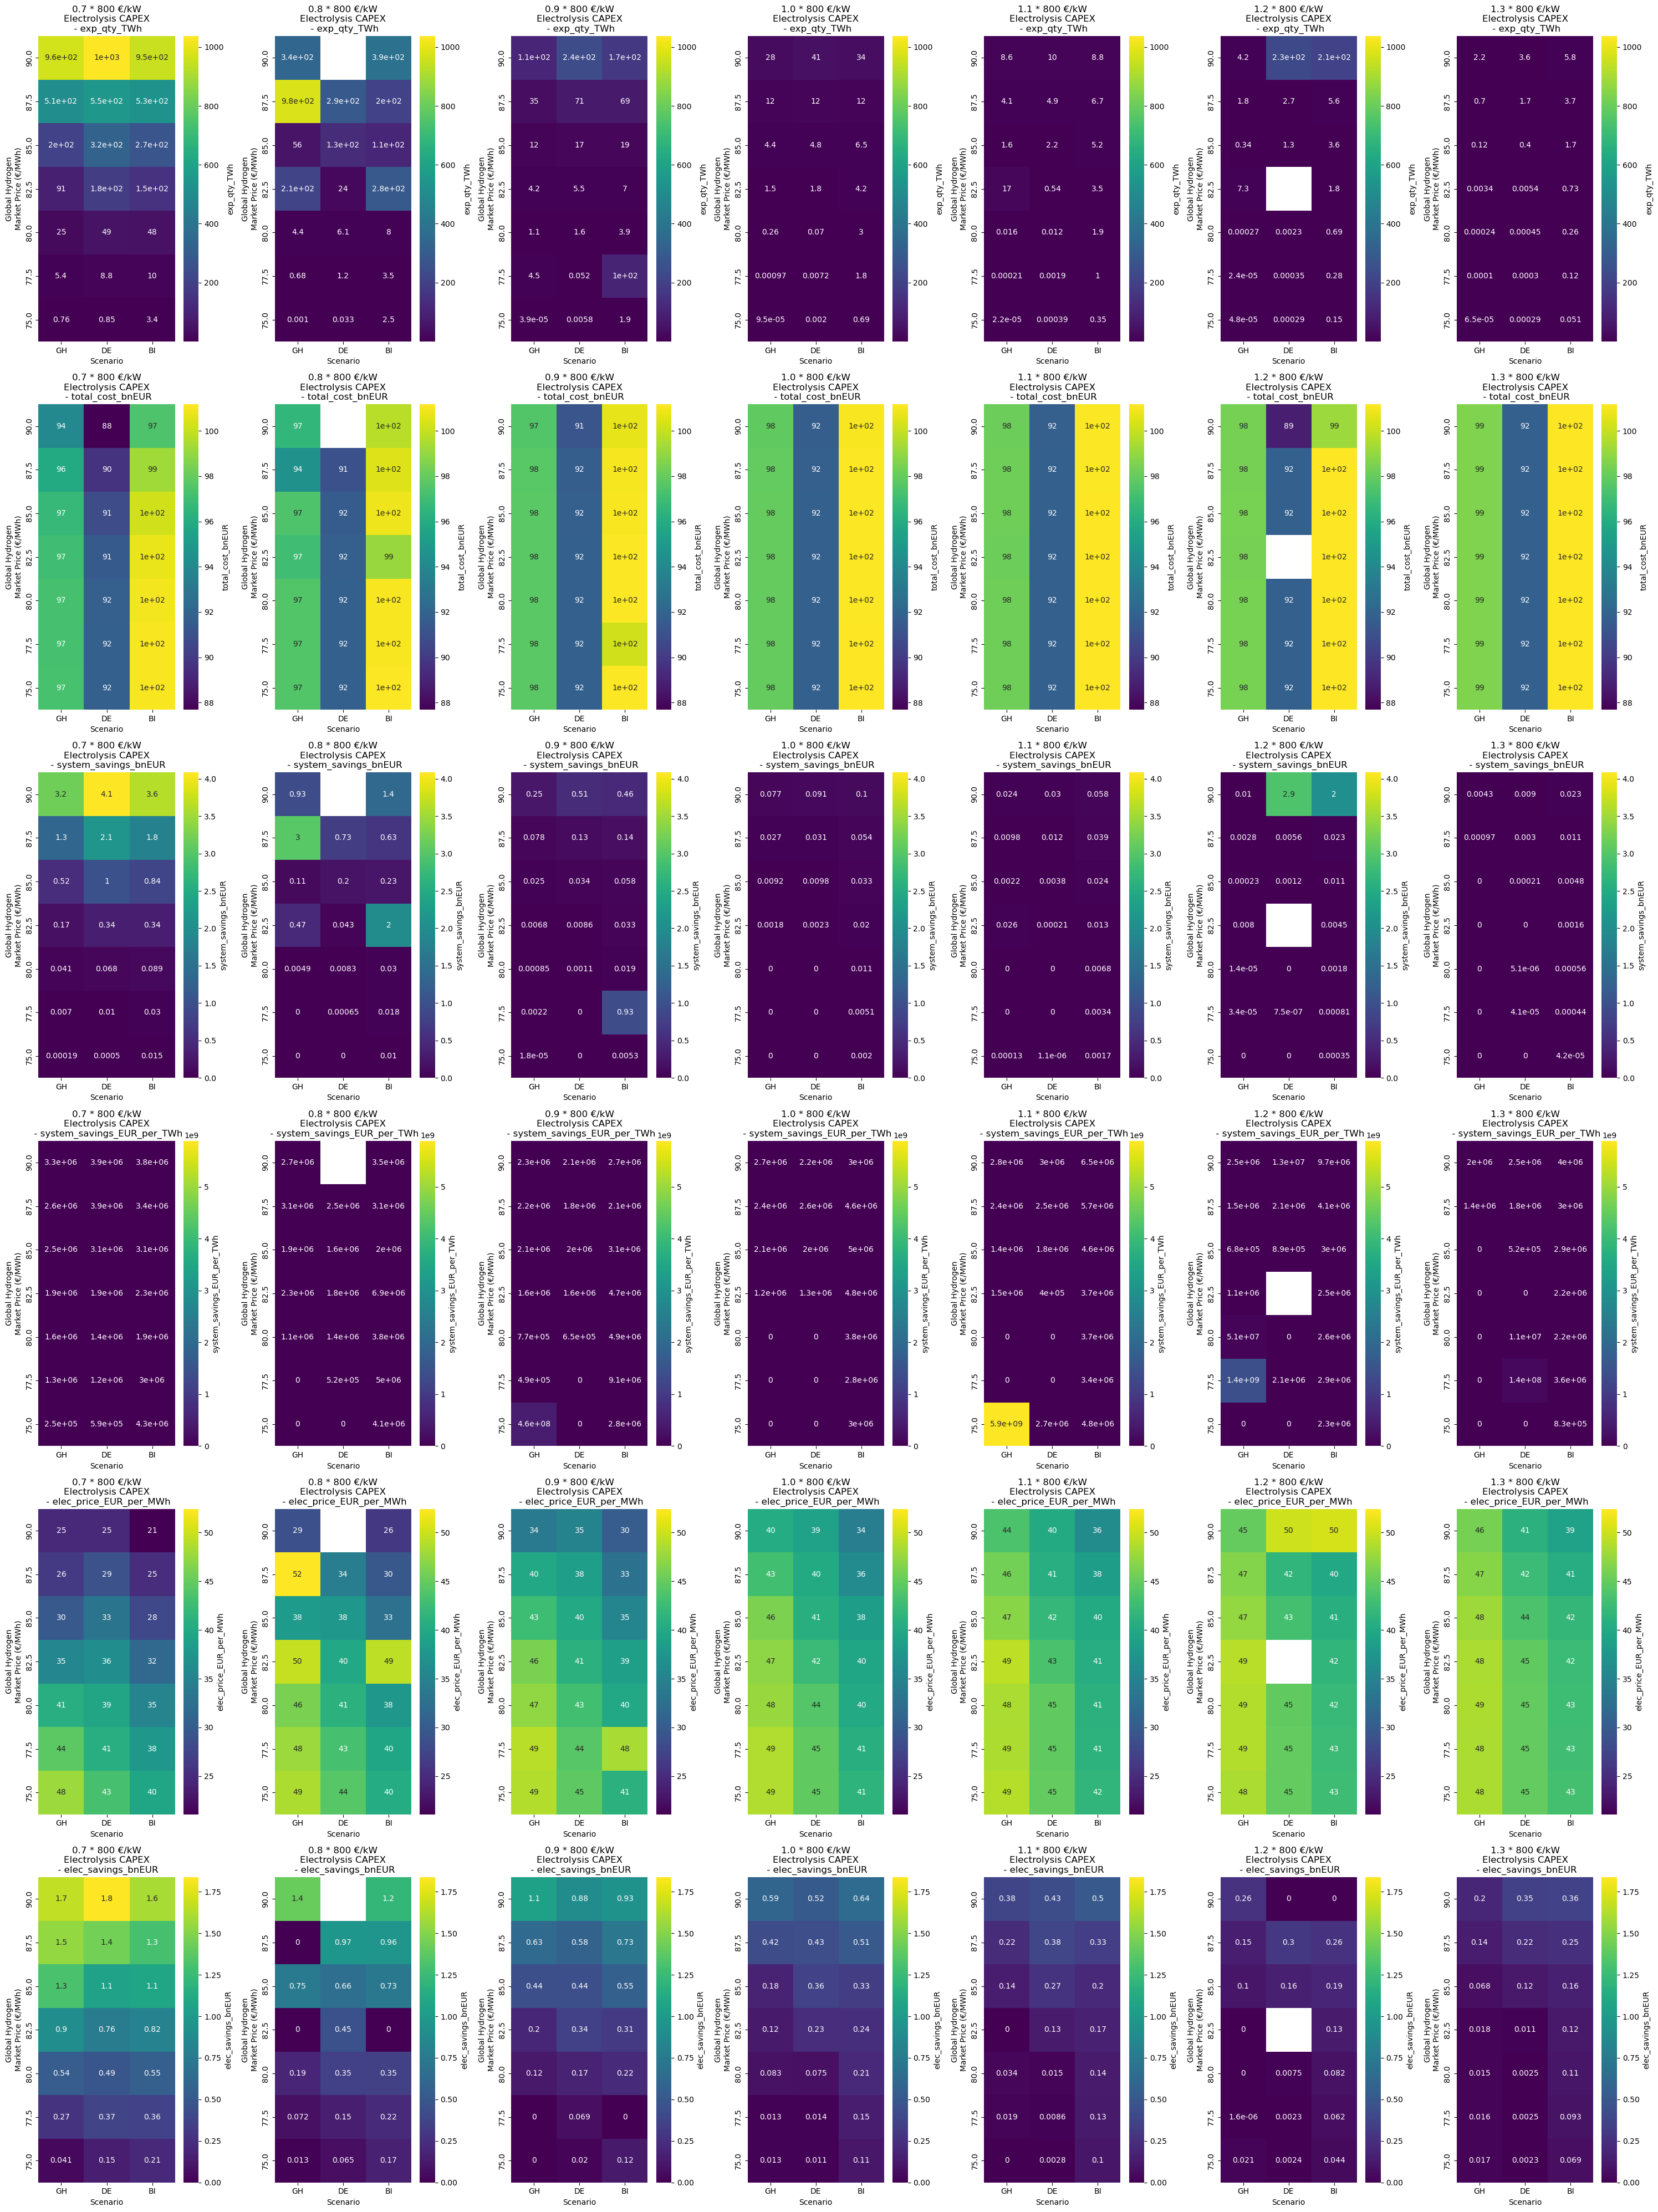

In [41]:
variables = ["exp_qty_TWh", "total_cost_bnEUR", "system_savings_bnEUR", "system_savings_EUR_per_TWh", "elec_price_EUR_per_MWh", "elec_savings_bnEUR"]

df = df.loc[df['mp_EUR_per_MWh'] != 'endogenous']
df["mp_EUR_per_MWh"] = df["mp_EUR_per_MWh"].astype(float)
df = df.loc[(df['mp_EUR_per_MWh'] <= 90) & (df['mp_EUR_per_MWh'] >= 75)]

scenarios = df["scenario"].unique()

fig, axs = plt.subplots(len(variables), len(df['ecc'].unique()), figsize=(30, 40))

for i, variable in enumerate(variables):
    vmin = df[variable].min()
    vmax = df[variable].max()
    
    for j, ecc in enumerate(df['ecc'].unique()):
        pivot_table = df[df["ecc"] == ecc].pivot(index="mp_EUR_per_MWh", columns="scenario", values=variable)
        pivot_table = pivot_table.sort_index(ascending=False).sort_index(axis=1, ascending=False)
        sns.heatmap(pivot_table, annot=True, cmap="viridis", cbar_kws={'label': variable}, ax=axs[i, j], vmin=vmin, vmax=vmax)
        axs[i, j].set_title(f"{ecc} * 800 €/kW\nElectrolysis CAPEX\n - {variable}")
        axs[i, j].set_xlabel("Scenario")
        axs[i, j].set_ylabel("Global Hydrogen\nMarket Price (€/MWh)")

plt.tight_layout()
plt.show()

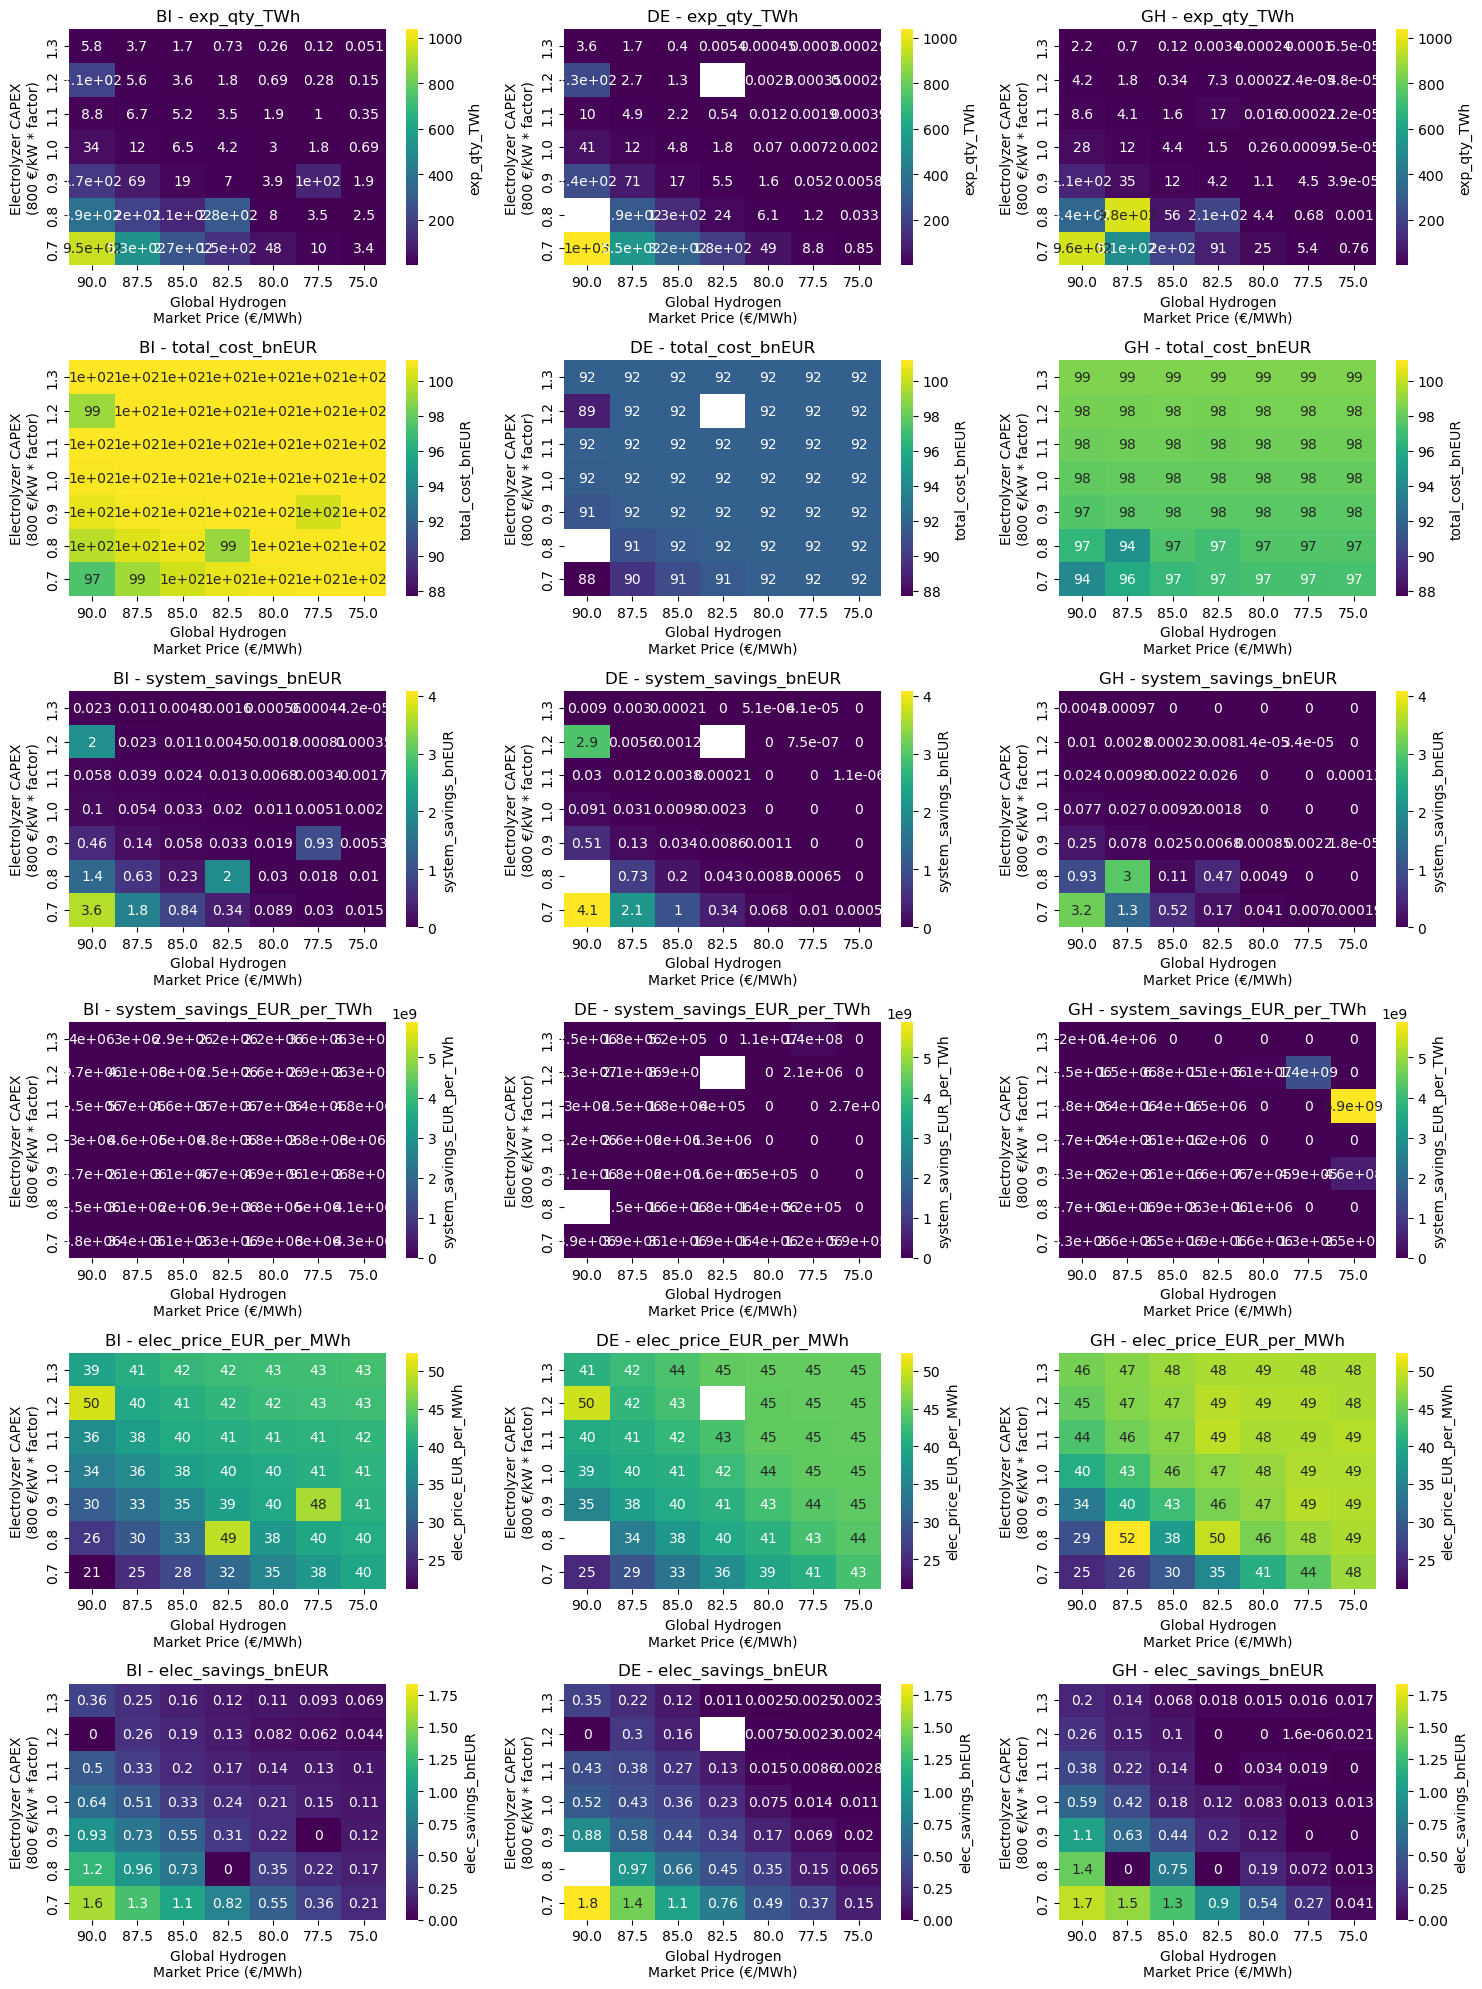

In [42]:
variables = ["exp_qty_TWh", "total_cost_bnEUR", "system_savings_bnEUR", "system_savings_EUR_per_TWh", "elec_price_EUR_per_MWh", "elec_savings_bnEUR"]
df = df.loc[df['mp_EUR_per_MWh'] != 'endogenous']
df["mp_EUR_per_MWh"] = df["mp_EUR_per_MWh"].astype(float)
df = df.loc[(df['mp_EUR_per_MWh'] <= 90) & (df['mp_EUR_per_MWh'] >= 75)]

scenarios = df["scenario"].unique()

fig, axs = plt.subplots(len(variables), len(scenarios), figsize=(15, 20))

for i, variable in enumerate(variables):
    vmin = df[variable].min()
    vmax = df[variable].max()
    
    for j, scenario in enumerate(scenarios):
        pivot_table = df[df["scenario"] == scenario].pivot(index="ecc", columns="mp_EUR_per_MWh", values=variable)
        pivot_table = pivot_table.sort_index(ascending=False).sort_index(axis=1, ascending=False)
        sns.heatmap(pivot_table, annot=True, cmap="viridis", cbar_kws={'label': variable}, ax=axs[i, j], vmin=vmin, vmax=vmax)
        axs[i, j].set_title(f"{scenario} - {variable}")
        axs[i, j].set_xlabel("Global Hydrogen\nMarket Price (€/MWh)")
        axs[i, j].set_ylabel("Electrolyzer CAPEX\n(800 €/kW * factor)")

plt.tight_layout()
plt.show()

In [25]:
df

,scenario,mp_EUR/MWh,ecc,exp_qty_TWh,total_cost_bnEUR,system_savings_bnEUR,system_savings_EUR/TWh,elec_price_EUR/MWh,elec_savings_bnEUR
